In [ ]:
# Core
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Import data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## EDA

In [ ]:
# Missing value
train.isna().sum().sort_values(ascending = False)

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64

<Axes: >

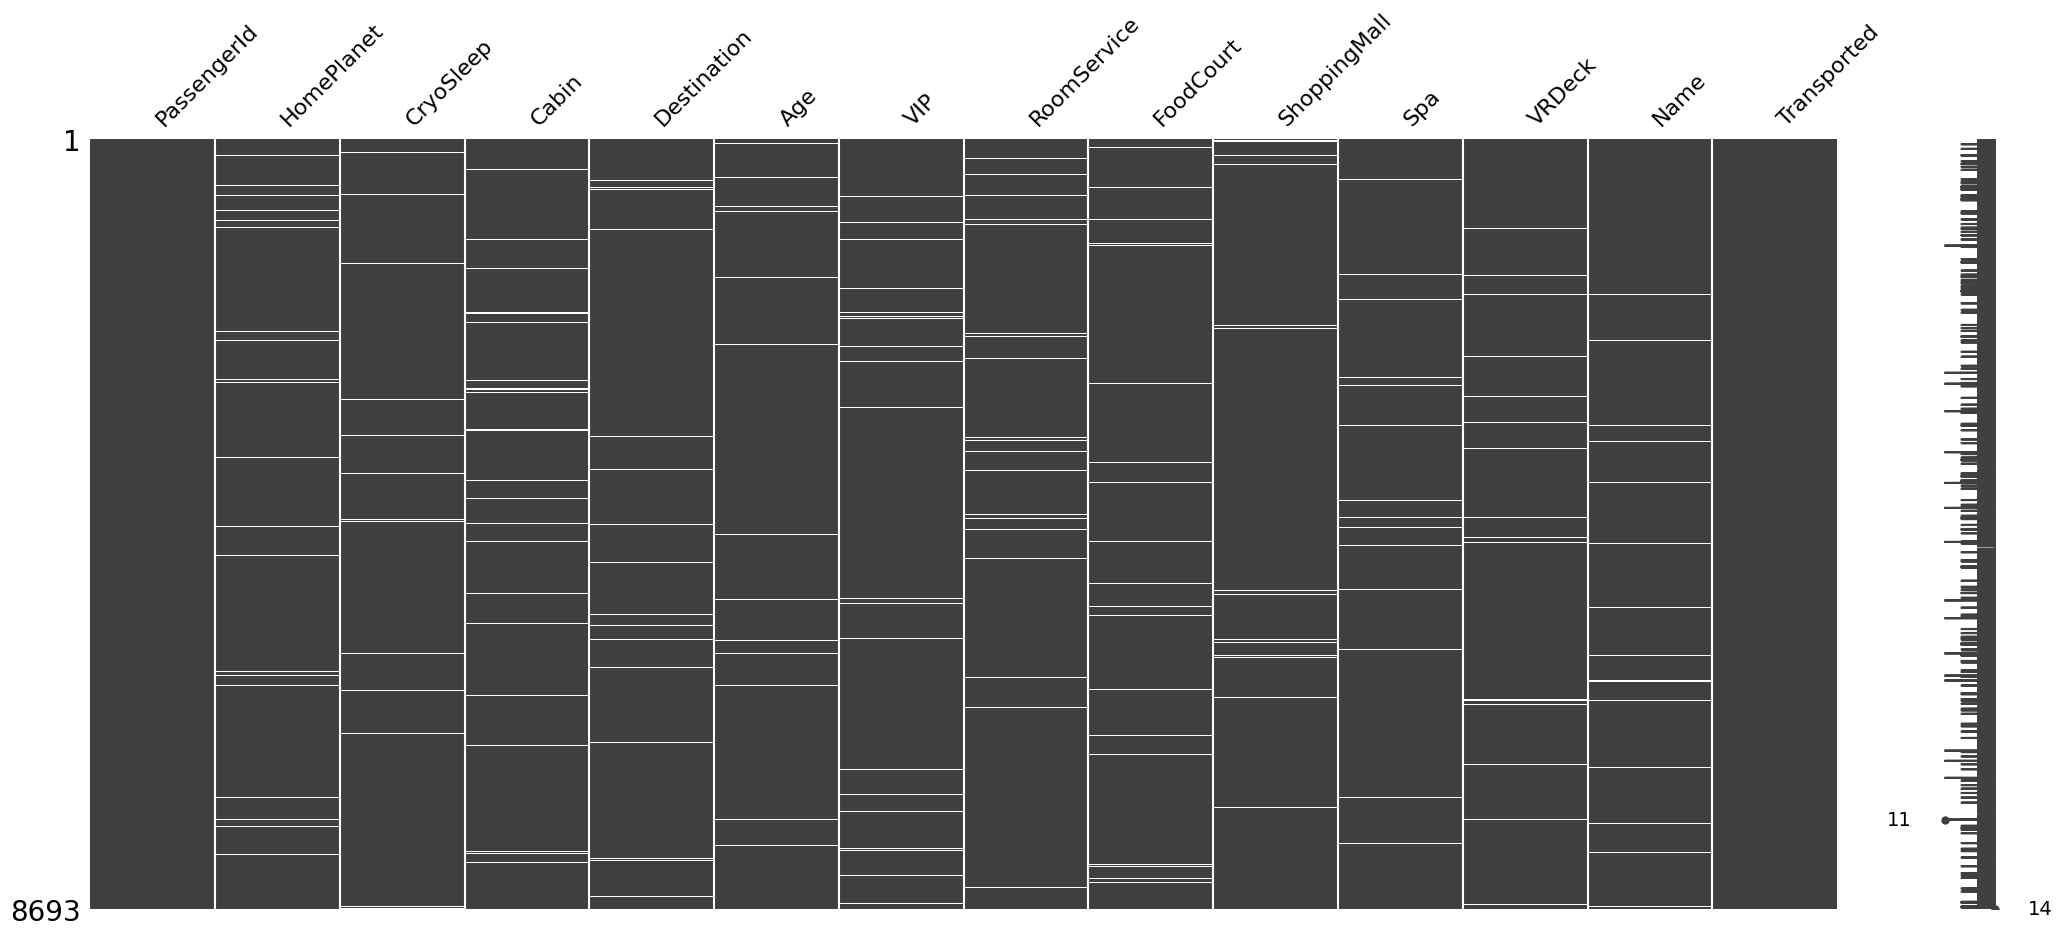

In [ ]:
msno.matrix(train)

In [ ]:
# Fill null values with median (numeric) and frequent values (categoric)
numeric_data = [column for column in train.select_dtypes(["int", "float"])]
categoric_data = [column for column in train.select_dtypes(exclude = ["int", "float"])]
test_categoric_data = [column for column in test.select_dtypes(exclude = ["int", "float"])]

for col in numeric_data:
    train[col].fillna(train[col].median(), inplace = True)
    test[col].fillna(test[col].median(), inplace = True)

#replace missing values in each categorical column with the most frequent value
for col in categoric_data:
    train[col].fillna(train[col].value_counts().index[0], inplace = True)
for col in test_categoric_data:
    test[col].fillna(test[col].value_counts().index[0], inplace = True)

# Check null values
train.isnull().sum().sum() + test.isnull().sum().sum()

0

In [ ]:
# Summary statistics
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,28.790291,220.009318,448.434027,169.572300,304.588865,298.261820
std,14.341404,660.519050,1595.790627,598.007164,1125.562559,1134.126417
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,41.000000,61.000000,22.000000,53.000000,40.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


Text(0.5, 0, 'Age (years)')

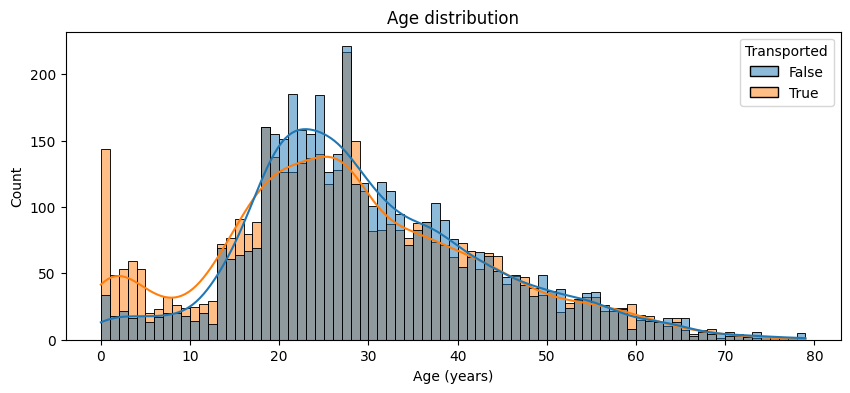

In [ ]:
# Age distribution
# Figure size
plt.figure(figsize=(10,4))

# Histogram
sns.histplot(data=train, x='Age', hue='Transported', binwidth=1, kde=True)

# Aesthetics
plt.title('Age distribution')
plt.xlabel('Age (years)')

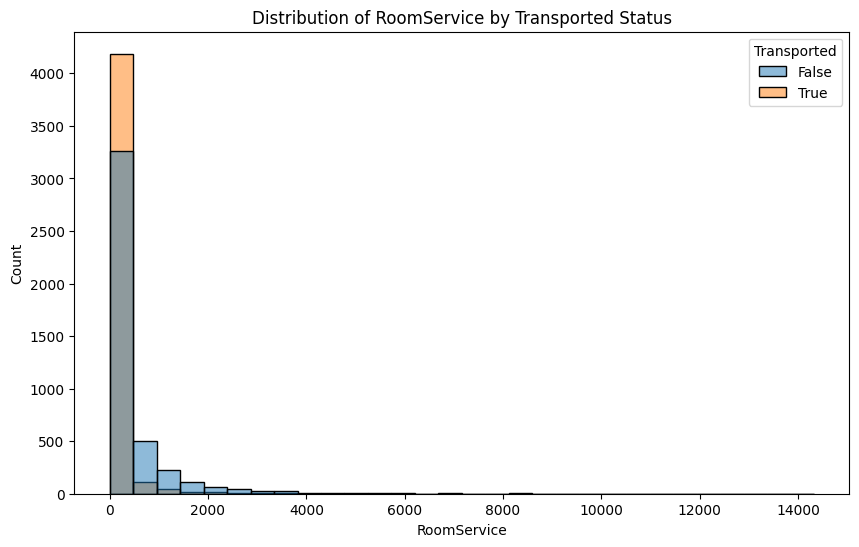

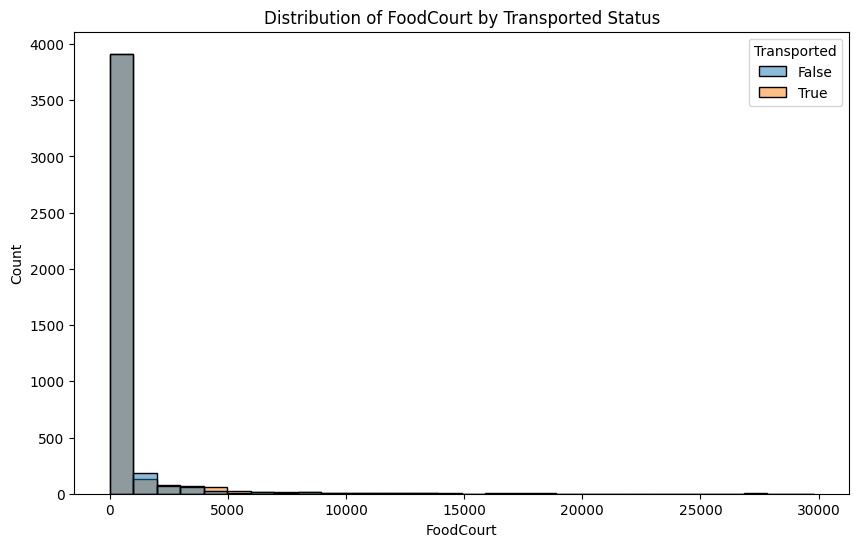

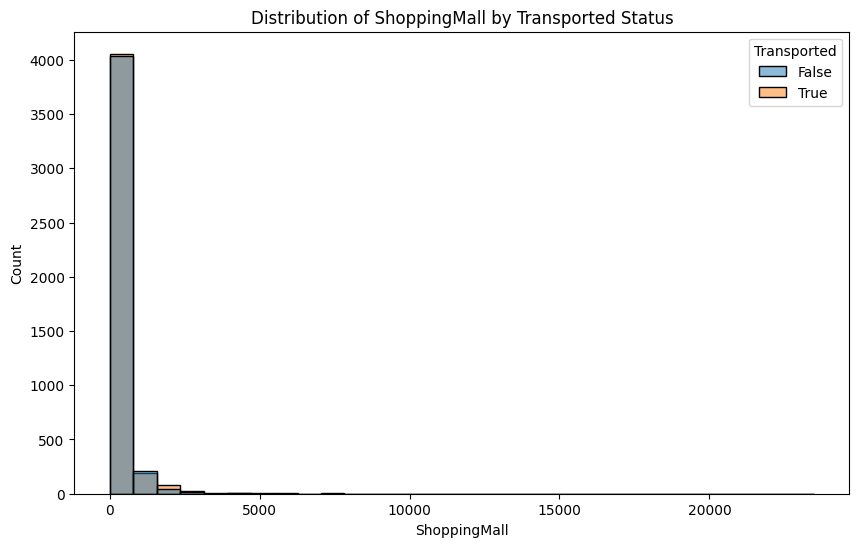

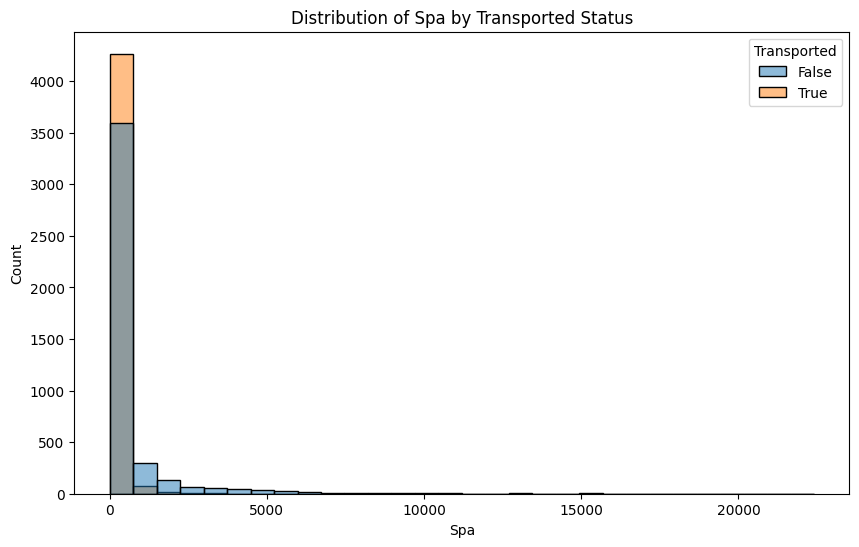

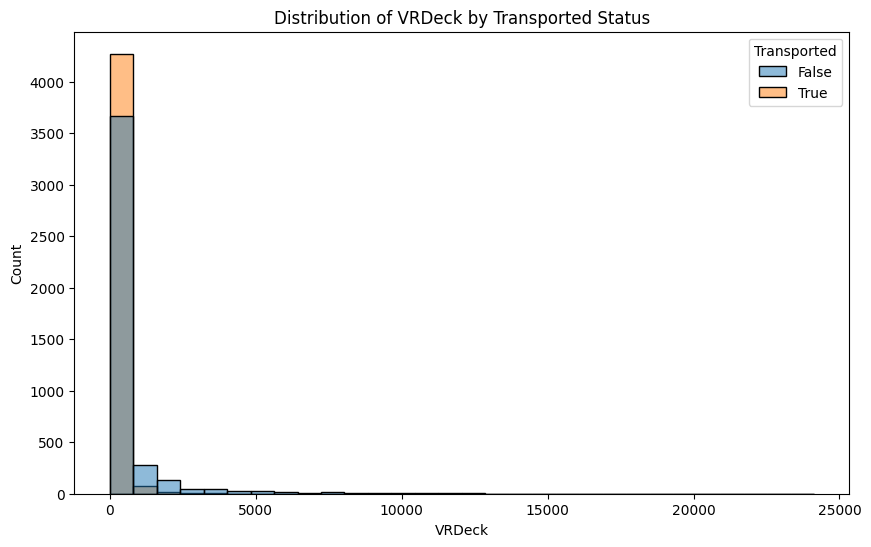

In [ ]:
# Expenditure features
exp_feats=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for i, var_name in enumerate(exp_feats):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=train, x=var_name, bins=30, kde=False, hue='Transported')
    plt.title(f'Distribution of {var_name} by Transported Status')
    plt.xlabel(var_name)
    plt.ylabel('Count')
    plt.show()

Feature Engineering Idea:
- Create a new feature that tracks the total expenditure across all 5 amenities.
- Take the log transform to reduce skew.

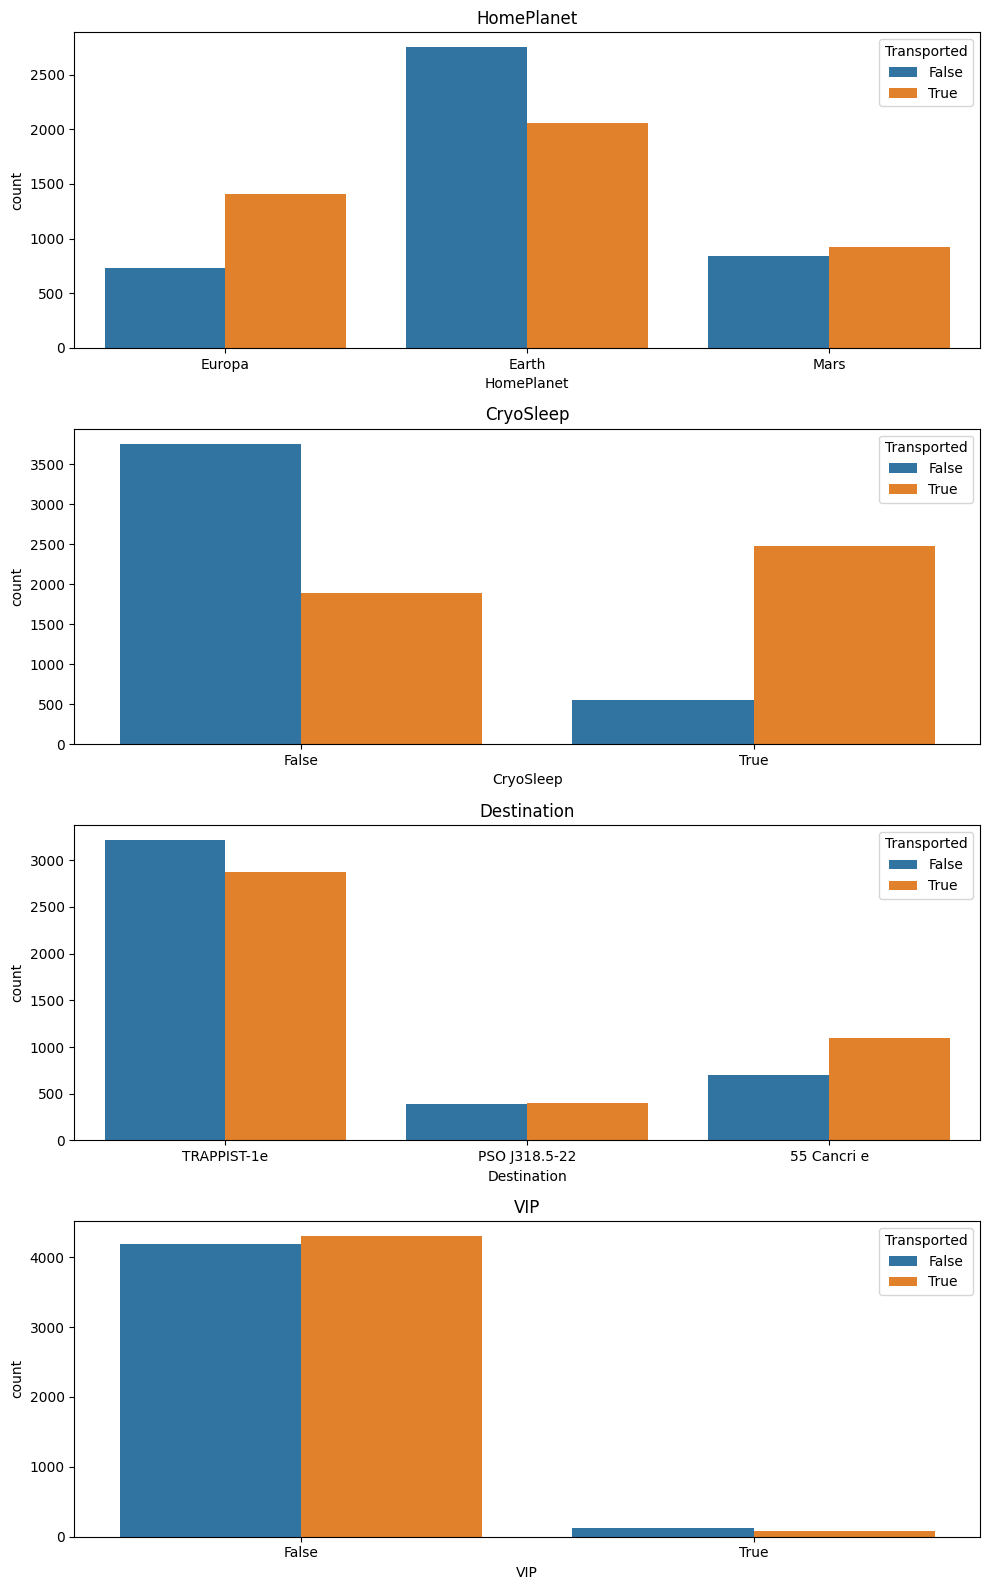

In [ ]:
# Categorical features
cat_feats=['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# Plot categorical features
fig=plt.figure(figsize=(10,16))
for i, var_name in enumerate(cat_feats):
    ax=fig.add_subplot(4,1,i+1)
    sns.countplot(data=train, x=var_name, axes=ax, hue='Transported')
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()

In [ ]:
# Qualitative features
qual_feats=['PassengerId', 'Cabin' ,'Name']

# Preview qualitative features
train[qual_feats].head()

,PassengerId,Cabin,Name
0,0001_01,B/0/P,Maham Ofracculy
1,0002_01,F/0/S,Juanna Vines
2,0003_01,A/0/S,Altark Susent
3,0003_02,A/0/S,Solam Susent
4,0004_01,F/1/S,Willy Santantines


Feature Engineering Idea:
- We can extract the group and group size from the PassengerId feature.
- We can extract the deck, number and side from the cabin feature.
- We could extract the surname from the name feature to identify families.

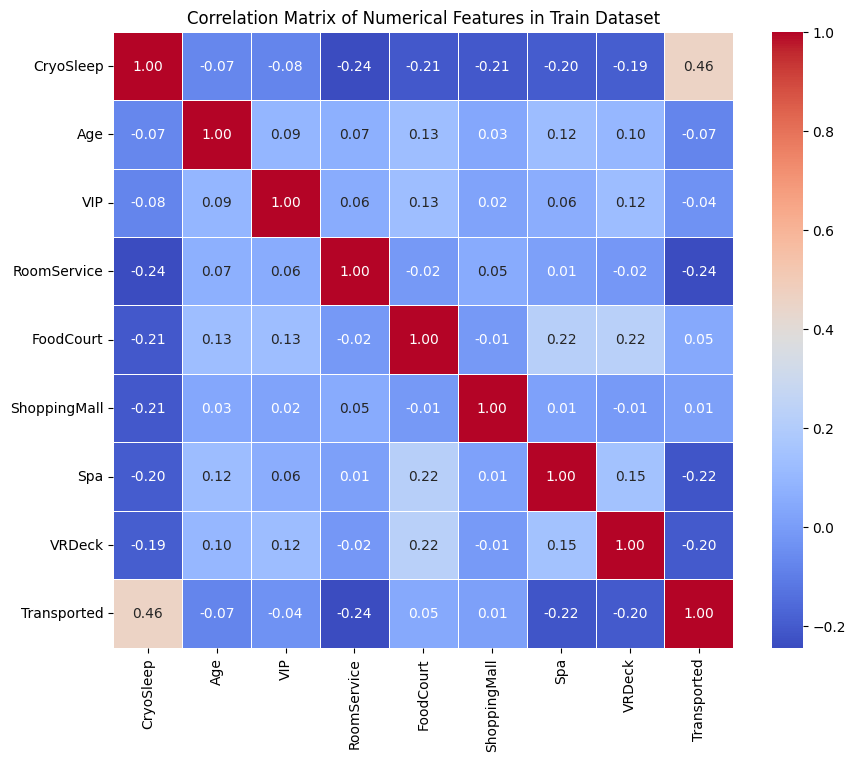

In [ ]:
# Correlation Matrix
train_numerical = train.select_dtypes(include=['number','bool'])

# Calculate the correlation matrix for numerical columns only
correlation_matrix_numerical = train_numerical.corr()

# Create a heatmap to visualize the correlation matrix of numerical columns
plt.figure(figsize=(10, 8))  # Adjust the size as needed
sns.heatmap(correlation_matrix_numerical, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features in Train Dataset')  # Optional: Add a title
plt.show()

In [ ]:
train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep          bool
Cabin            object
Destination      object
Age             float64
VIP                bool
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

## Feature Engineering

In [ ]:
train.shape

(8693, 14)

In [ ]:
test.shape

(4277, 13)

In [ ]:
# Expenditure
# New features - training set
train['Expenditure']=train[exp_feats].sum(axis=1)
train['No_spending']=(train['Expenditure']==0).astype(int)

# New features - test set
test['Expenditure']=test[exp_feats].sum(axis=1)
test['No_spending']=(test['Expenditure']==0).astype(int)

In [ ]:
# Extract passenger group and group size from PassengerID
# New feature - Group
train['Group'] = train['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
test['Group'] = test['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)

# New feature - Group size
train['Group_size']=train['Group'].map(lambda x: pd.concat([train['Group'], test['Group']]).value_counts()[x])
test['Group_size']=test['Group'].map(lambda x: pd.concat([train['Group'], test['Group']]).value_counts()[x])

In [ ]:
# Not use 'Group' in the model to avoid overfitting
train['Group'].nunique()

6217

In [ ]:
# Check group size and create 'solo' column
train['Group_size'].value_counts()

# New feature
train['Solo']=(train['Group_size']==1).astype(int)
test['Solo']=(test['Group_size']==1).astype(int)

In [ ]:
# Create 'deck' and 'side' features from 'cabin' column

# New features - training set
train['Cabin_deck'] = train['Cabin'].apply(lambda x: x.split('/')[0])
train['Cabin_number'] = train['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
train['Cabin_side'] = train['Cabin'].apply(lambda x: x.split('/')[2])

# New features - test set
test['Cabin_deck'] = test['Cabin'].apply(lambda x: x.split('/')[0])
test['Cabin_number'] = test['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
test['Cabin_side'] = test['Cabin'].apply(lambda x: x.split('/')[2])

In [ ]:
# New feature - Surname
train['Surname']=train['Name'].str.split().str[-1]
test['Surname']=test['Name'].str.split().str[-1]

# New feature - Family size
train['Family_size']=train['Surname'].map(lambda x: pd.concat([train['Surname'],test['Surname']]).value_counts()[x])
test['Family_size']=test['Surname'].map(lambda x: pd.concat([train['Surname'],test['Surname']]).value_counts()[x])

In [ ]:
train.drop(['PassengerId', 'Group', 'Group_size','Cabin', 'Name'], axis=1, inplace=True)
test.drop(['PassengerId', 'Group', 'Group_size', 'Cabin', 'Name'], axis=1, inplace=True)

In [ ]:
train.dtypes

HomePlanet       object
CryoSleep          bool
Destination      object
Age             float64
VIP                bool
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Transported        bool
Expenditure     float64
No_spending       int64
Solo              int64
Cabin_deck       object
Cabin_number      int64
Cabin_side       object
Surname          object
Family_size       int64
dtype: object

In [ ]:
# Update 'Cabin_number' to object
train['Cabin_number'] = train['Cabin_number'].astype('object')

In [ ]:
# Apply log transform
for col in ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Expenditure']:
    train[col]=np.log(1+train[col])
    test[col]=np.log(1+test[col])

In [ ]:
# Encoding categorical features (Label Encoding)
label_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'No_spending', 'Solo', 'Cabin_deck', 'Cabin_number', 'Cabin_side', 'Surname' ]
def label_encoder(train,test,columns):
    for col in columns:
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        train[col] = LabelEncoder().fit_transform(train[col])
        test[col] =  LabelEncoder().fit_transform(test[col])
    return train, test

train, test = label_encoder(train,test, label_cols)

In [ ]:
# Standardization
numerical_cols = train.select_dtypes(include=['number']).columns

# Initializing the StandardScaler
scaler = StandardScaler()

# Fitting the scaler to the numerical columns and transforming the data
train[numerical_cols] = scaler.fit_transform(train[numerical_cols])
test[numerical_cols] = scaler.fit_transform(test[numerical_cols])

In [ ]:
# Splitting the train
X = train.drop('Transported', axis=1)
y = train['Transported']
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  test_size=0.2,
                                                  stratify=train['Transported'],
                                                  random_state=42)
X_train.to_csv("X_train.csv")
X_val.to_csv("X_val.csv")
y_train.to_csv("y_train.csv")
y_val.to_csv("y_val.csv")

## Kevin: Tree and Random Forest (Using random_state = 42 for CV)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV

In [ ]:
tree_params = {'max_depth': np.arange(1, 21)}

# Initialize cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize Decision Tree classifier
tree_clf = DecisionTreeClassifier(random_state=42)

# Perform cross-validation for hyperparameter tuning
tree_grid = GridSearchCV(tree_clf, tree_params, cv=cv, scoring='accuracy')
tree_grid.fit(X_train, y_train)

# Get the best Decision Tree model
best_tree_model = tree_grid.best_estimator_
print(best_tree_model)

DecisionTreeClassifier(max_depth=7, random_state=42)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Random Forest hyperparameter tuning with RandomizedSearchCV
# Define hyperparameters to tune
rf_params = {'n_estimators': [100, 200],
             'max_features': ['auto', None],
             'max_depth': [None, 10, 20, 30],
             'min_samples_split': [2, 5, 15],
             'min_samples_leaf': [1, 5, 12]}

# Initialize Random Forest classifier
rf_clf = RandomForestClassifier(random_state=42)

# Perform cross-validation for hyperparameter tuning using RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator = rf_clf, param_distributions = rf_params,
                               n_iter = 100, cv = cv, scoring='accuracy', random_state=42, verbose = 5)

# Perform cross-validation for hyperparameter tuning
#rf_grid = GridSearchCV(rf_clf, rf_params, cv=cv, scoring='accuracy', verbose=10)
rf_random.fit(X_train, y_train)

# Get the best Random Forest model
best_rf_model = rf_random.best_estimator_
print(best_rf_model)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV 1/10] END max_depth=30, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=200;, score=0.818 total time=   2.0s
[CV 2/10] END max_depth=30, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=200;, score=0.773 total time=   1.9s
[CV 3/10] END max_depth=30, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=200;, score=0.810 total time=   2.3s
[CV 4/10] END max_depth=30, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=200;, score=0.790 total time=   2.3s
[CV 5/10] END max_depth=30, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=200;, score=0.781 total time=   2.0s
[CV 6/10] END max_depth=30, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=200;, score=0.799 total time=   1.9s
[CV 7/10] END max_depth=30, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=200;, 

In [ ]:
import time

best_tree_model = DecisionTreeClassifier(max_depth=7, random_state=42)
best_rf_model = RandomForestClassifier(max_depth=10, max_features=None, min_samples_leaf=5,
                       min_samples_split=15, random_state=42)

# Record the start time
start_time = time.time()
# Fit the model on the entire training set
best_tree_model.fit(X_train, y_train)
# Record the end time
end_time = time.time()
# Calculate the duration
duration = end_time - start_time
print("Training time:", duration, "seconds")


# Decision Tree
tree_val_pred = best_tree_model.predict(X_val)
tree_val_accuracy = accuracy_score(y_val, tree_val_pred)

# Record the start time
start_time = time.time()
# Fit the model on the entire training set
best_rf_model.fit(X_train, y_train)
# Record the end time
end_time = time.time()
# Calculate the duration
duration = end_time - start_time
print("Training time:", duration, "seconds")

# Random Forest
rf_val_pred = best_rf_model.predict(X_val)
rf_val_accuracy = accuracy_score(y_val, rf_val_pred)

print("Decision Tree validation accuracy:", tree_val_accuracy)
print("Random Forest validation accuracy:", rf_val_accuracy)

Training time: 0.061949968338012695 seconds
Training time: 6.15765118598938 seconds
Decision Tree validation accuracy: 0.7814836112708453
Random Forest validation accuracy: 0.8033352501437608


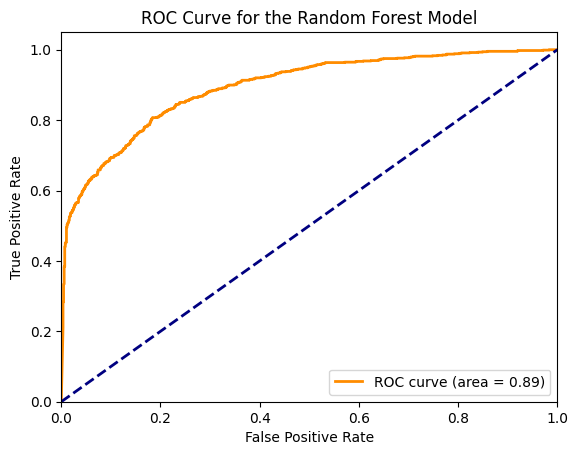

In [ ]:
# Plot ROC curve for the selected model (Random Forest in this case)
rf_probs = best_rf_model.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, rf_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for the Random Forest Model')
plt.legend(loc="lower right")
plt.show()

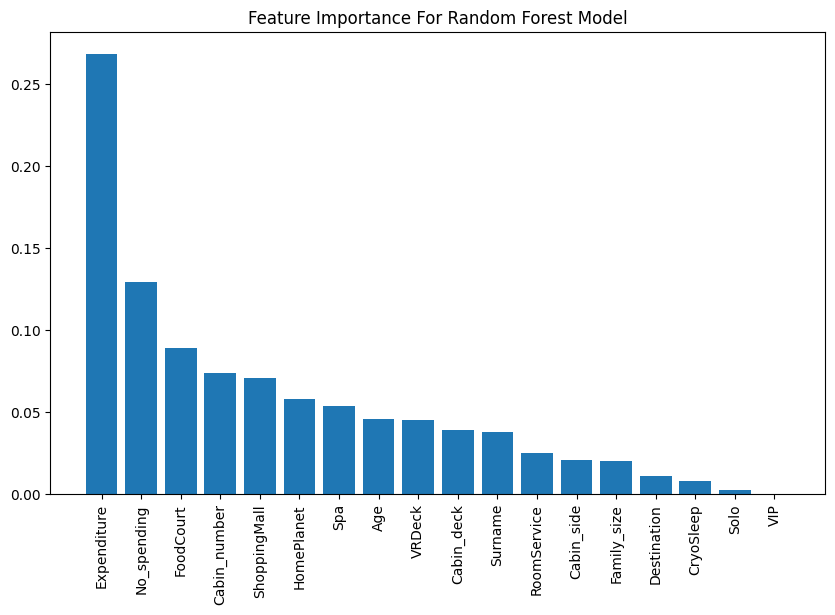

In [ ]:
# Assuming best_rf_model is your trained RandomForest model
feature_importances = best_rf_model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importance For Random Forest Model")
plt.bar(range(X_train.shape[1]), feature_importances[indices])
plt.xticks(range(X_train.shape[1]), names, rotation=90)
plt.show()

# Xinran: Logistic, svm, basic NN

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
import numpy as np

import time
# Record the start time
start_time = time.time()

# Prepare the logistic regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

'''
# Prepare cross-validation (k=10, random_state=42)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# training accuracy
logistic_accuracy_training = cross_val_score(logistic_model,
                                           X_train, y_train.values.ravel(),
                                           cv=cv,
                                           scoring='accuracy')

# training AUC
y_scores_logistic = cross_val_predict(logistic_model,
                                      X_train, y_train.values.ravel(),
                                      cv=10,
                                      method="decision_function")
logistic_auc_training = roc_auc_score(y_train, y_scores_logistic)
'''

# Fit the model on the entire training set
logistic_model.fit(X_train, y_train)

# Record the end time
end_time = time.time()
# Calculate the duration
duration = end_time - start_time
print("Training time:", duration, "seconds")

# Predict on validation set
y_val_pred = logistic_model.predict(X_val)
y_val_pred_proba = logistic_model.predict_proba(X_val)[:,1]

# Calculate accuracy and ROC AUC score for the validation set
accuracy_val = accuracy_score(y_val, y_val_pred)
roc_auc_val = roc_auc_score(y_val, y_val_pred_proba)

# Calculate mean accuracy
logistic_mean_accuracy = np.mean(accuracy_val)

logistic_mean_accuracy, roc_auc_val

Training time: 0.03689742088317871 seconds


(0.7694077055779184, 0.8518045259977671)

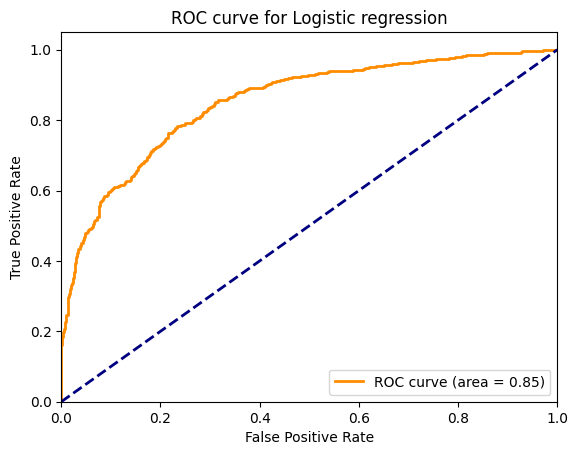

In [ ]:
# ROC curve for logistic
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_proba)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Logistic regression')
plt.legend(loc="lower right")
plt.show()

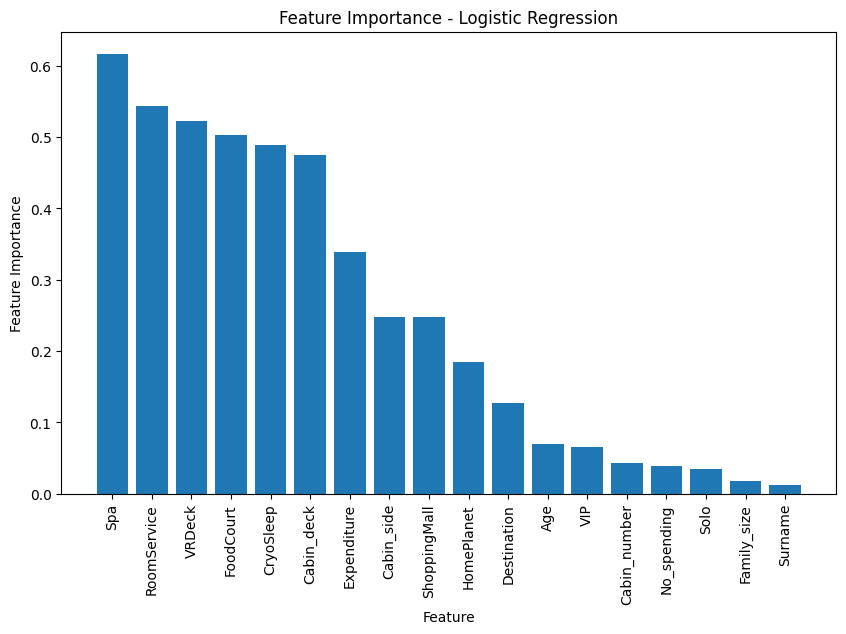

In [ ]:
import matplotlib.pyplot as plt

# Get the coefficients of the logistic regression model
coefficients = logistic_model.coef_[0]

# Get the absolute values of coefficients for feature importance
feature_importance = abs(coefficients)

# Get the names of the features
feature_names = X_train.columns

# Sort feature importance and feature names in descending order
sorted_indices = feature_importance.argsort()[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_feature_importance)), sorted_feature_importance, align='center')
plt.xticks(range(len(sorted_feature_importance)), sorted_feature_names,rotation=90)
plt.ylabel('Feature Importance')
plt.xlabel('Feature')
plt.title('Feature Importance - Logistic Regression')
plt.show()


## SVM

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict
import numpy as np
import matplotlib.pyplot as plt

import time
# Record the start time
start_time = time.time()

# Prepare the model
svc_model = SVC(probability=True, random_state=42)

'''
# Prepare cross-validation (k=10, random_state=42)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform 10-fold cross-validation to estimate accuracy
svm_accuracy_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

# Predict probabilities for ROC curve using cross-validation
y_probas = cross_val_predict(model, X_train, y_train, cv=cv, method='predict_proba')
svm_roc_auc_score = roc_auc_score(y_train, y_probas)

# Calculate mean accuracy
svm_mean_accuracy = np.mean(svm_accuracy_scores)
'''

# Fit the model on the entire training set
svc_model.fit(X_train, y_train)

# Record the end time
end_time = time.time()
# Calculate the duration
duration = end_time - start_time
print("Training time:", duration, "seconds")

# Predict on validation set
y_val_pred = svc_model.predict(X_val)
y_val_pred_proba = svc_model.predict_proba(X_val)[:,1]

# Calculate accuracy and ROC AUC score for the validation set
accuracy_val = accuracy_score(y_val, y_val_pred)
roc_auc_val = roc_auc_score(y_val, y_val_pred_proba)

# Calculate val accuracy
svc_mean_accuracy = np.mean(accuracy_val)

svc_mean_accuracy, roc_auc_val

Training time: 10.810791254043579 seconds


(0.7849338700402531, 0.8745390138467808)

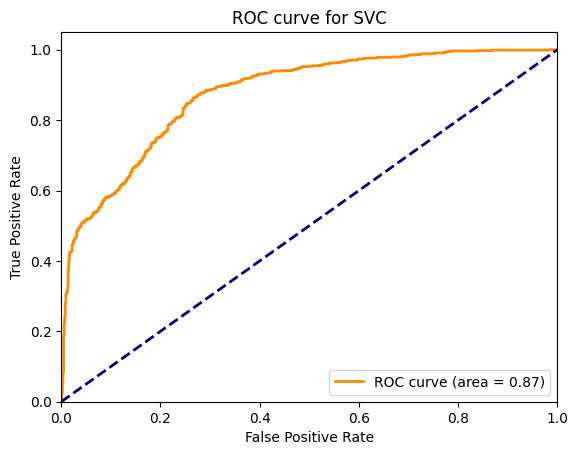

In [ ]:
# ROC curve for logistic
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_proba)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for SVC')
plt.legend(loc="lower right")
plt.show()

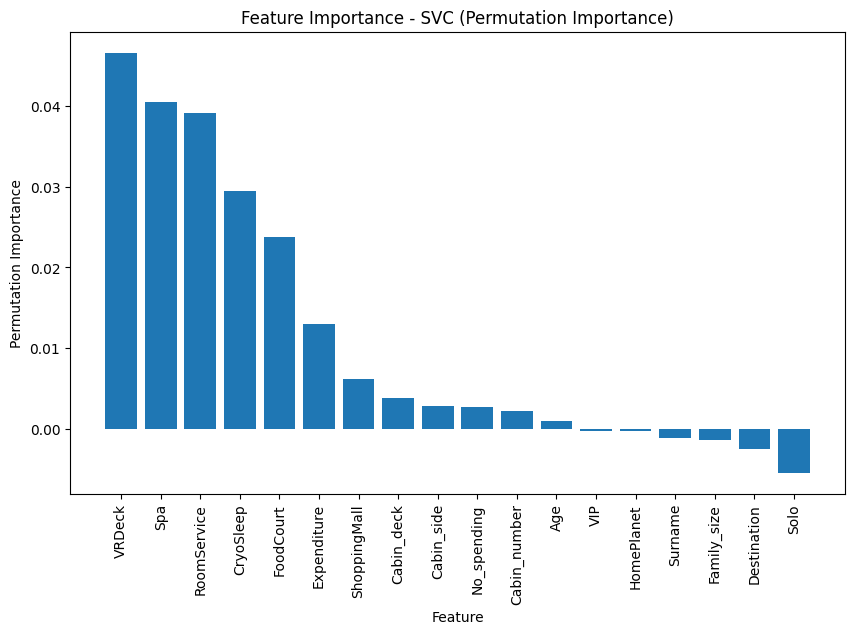

In [ ]:
from sklearn.inspection import permutation_importance

# Compute permutation importance
result = permutation_importance(svc_model, X_val, y_val, n_repeats=10, random_state=42)

# Get sorted indices and feature names
sorted_indices = result.importances_mean.argsort()[::-1]
sorted_feature_importance = result.importances_mean[sorted_indices]
sorted_feature_names = X_train.columns[sorted_indices]

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_feature_importance)), sorted_feature_importance, align='center')
plt.xticks(range(len(sorted_feature_importance)), sorted_feature_names, rotation =90)
plt.ylabel('Permutation Importance')
plt.xlabel('Feature')
plt.title('Feature Importance - SVC (Permutation Importance)')
plt.show()

## Basic NN

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Define different sizes for the hidden layer
hidden_layer_sizes = [(5,), (10,), (20,), (50,), (100,)]

# Record the average cross-validation score for each configuration
cv_scores = {}
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

for size in hidden_layer_sizes:
    model = MLPClassifier(hidden_layer_sizes=size, max_iter=1000, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    cv_scores[size] = scores.mean()

# Find the best hidden layer size based on the highest mean accuracy
best_hidden_layer_size = max(cv_scores, key=cv_scores.get)
best_accuracy = cv_scores[best_hidden_layer_size]

best_hidden_layer_size, best_accuracy

((10,), 0.7886159348383363)

In [ ]:
import time
# Record the start time
start_time = time.time()

#best_nn_model = MLPClassifier(hidden_layer_sizes= best_hidden_layer_size, max_iter=1000, random_state=42)
best_nn_model = MLPClassifier(hidden_layer_sizes= 10, max_iter=1000, random_state=42)
best_nn_model.fit(X_train, y_train)

# Record the end time
end_time = time.time()
# Calculate the duration
duration = end_time - start_time
print("Training time:", duration, "seconds")

nn_val_pred = best_nn_model.predict(X_val)
nn_val_accuracy = accuracy_score(y_val, nn_val_pred)

print("NN validation accuracy:", nn_val_accuracy)

Training time: 3.796481132507324 seconds
NN validation accuracy: 0.7843588269120184


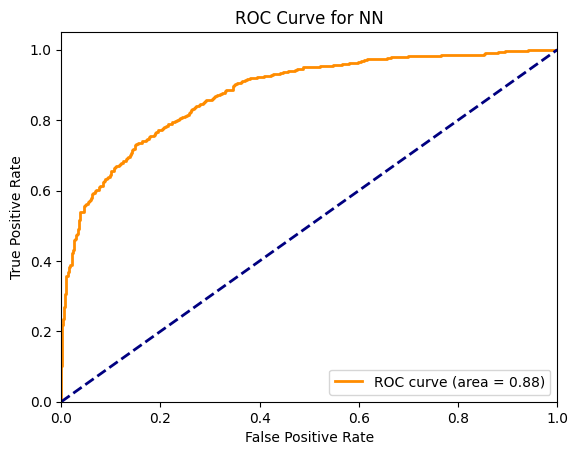

In [ ]:
# Plot ROC curve for the selected model (Random Forest in this case)
nn_probs = best_nn_model.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, nn_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for NN')
plt.legend(loc="lower right")
plt.show()

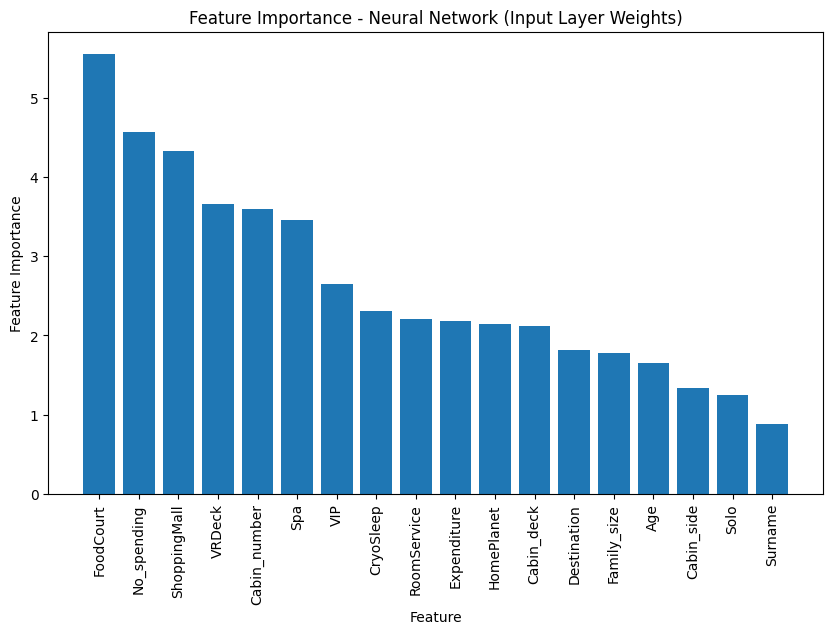

In [ ]:
# Get the weights connecting input layer to the first hidden layer
input_layer_weights = best_nn_model.coefs_[0]

# Compute feature importance based on the sum of absolute weights for each feature
feature_importance = np.sum(np.abs(input_layer_weights), axis=1)

# Get the feature names
feature_names = X_train.columns

# Sort feature importance and feature names in descending order
sorted_indices = feature_importance.argsort()[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_feature_importance)), sorted_feature_importance, align='center')
plt.xticks(range(len(sorted_feature_importance)), sorted_feature_names, rotation =90)
plt.ylabel('Feature Importance')
plt.xlabel('Feature')
plt.title('Feature Importance - Neural Network (Input Layer Weights)')
plt.show()

## Siyan: gradientboosting (LGBMClassifier+XGBClassifier)

In [ ]:
X_train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Expenditure,No_spending,Solo,Cabin_deck,Cabin_number,Cabin_side,Surname,Family_size
4561,0.440385,-0.732770,0.620545,0.084356,-0.153063,2.458002,1.177977,0.311020,1.164139,0.293812,1.151670,-0.851353,0.899532,-1.320046,-0.749609,-1.032865,-0.079495,-0.228971
3305,-0.817259,1.364685,0.620545,-0.543234,-0.153063,-0.638181,-0.650080,-0.622995,-0.664035,-0.640034,-1.152845,1.174601,-1.111690,0.932414,0.756244,0.968181,-1.205166,-0.132793
2225,-0.817259,1.364685,0.620545,-0.822163,-0.153063,-0.638181,-0.650080,-0.622995,-0.664035,-0.640034,-1.152845,1.174601,-1.111690,0.932414,0.345198,0.968181,0.695967,-0.004555
447,-0.817259,-0.732770,0.620545,-0.473502,-0.153063,-0.638181,-0.039138,-0.622995,2.004663,-0.640034,0.851217,-0.851353,0.899532,-0.193816,0.163389,-1.032865,0.361393,-0.196912
1373,-0.817259,-0.732770,0.620545,2.106589,-0.153063,-0.638181,-0.650080,-0.622995,-0.664035,1.773101,0.643792,-0.851353,0.899532,0.932414,0.003318,-1.032865,1.136855,-0.068674


In [ ]:
X_train.columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Expenditure',
       'No_spending', 'Solo', 'Cabin_deck', 'Cabin_number', 'Cabin_side',
       'Surname', 'Family_size'],
      dtype='object')

### LGBMClassifier

In [ ]:
import lightgbm as lgb
from sklearn.metrics import classification_report


In [ ]:
# Define the parameter grid for grid search
param_grid = {
    'objective': ['binary'],
    'boosting_type': ['gbdt'],
    'num_leaves': [30, 50, 75,100],
    'learning_rate': [0.05, 0.1, 0.2],
    'feature_fraction': [0.9, 0.8, 0.7,0.6,0.5]
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# Create an LGBMClassifier
clf = lgb.LGBMClassifier(verbose=-1)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=cv)

# Fit the model to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_clf = grid_search.best_estimator_

# Print the best parameters
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.1, 'num_leaves': 30, 'objective': 'binary'}
Training time: 0.18375754356384277 seconds
Cross-Validation Scores: [0.82758621 0.8045977  0.80028736 0.81896552 0.82877698 0.78273381
 0.8057554  0.79136691 0.82158273 0.80143885]
Mean CV Score: 0.8083091457868188
Standard Deviation of CV Scores: 0.014674015531041905


In [ ]:
# Record the time
start_time = time.time()

best_clf = lgb.LGBMClassifier(verbose=-1,
                              boosting_type = 'gbdt',
                              feature_fraction= 0.9,
                              learning_rate = 0.1,
                              num_leaves = 30,
                              objective = 'binary')
# Fit the best model on the entire training set
best_clf.fit(X_train, y_train)

# Record the end time
end_time = time.time()
# Calculate the duration
duration = end_time - start_time
print("Training time:", duration, "seconds")

# Perform cross-validation with the best model
cross_val_scores = cross_val_score(best_clf, X_train, y_train, cv=cv, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores:", cross_val_scores)

# Print the mean and standard deviation of cross-validation scores
print("Mean CV Score:", cross_val_scores.mean())
print("Standard Deviation of CV Scores:", cross_val_scores.std())

Training time: 0.5622401237487793 seconds
Cross-Validation Scores: [0.82758621 0.8045977  0.80028736 0.81896552 0.82877698 0.78273381
 0.8057554  0.79136691 0.82158273 0.80143885]
Mean CV Score: 0.8083091457868188
Standard Deviation of CV Scores: 0.014674015531041905


In [ ]:
predictions = best_clf.predict(X_val)
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

       False       0.82      0.81      0.81       863
        True       0.81      0.82      0.82       876

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739



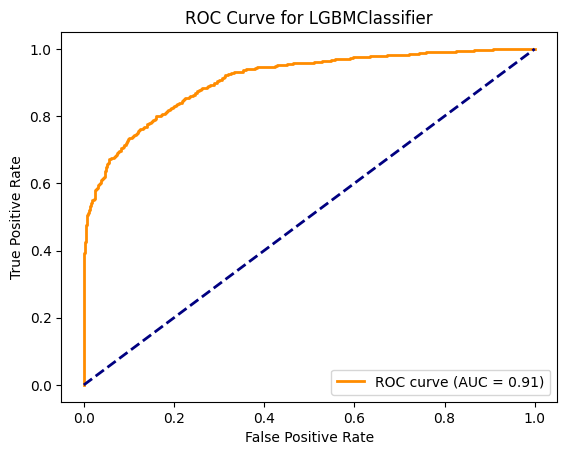

In [ ]:
## ROC of LGBMClassifier
# Predict probabilities on the validation set
from sklearn.metrics import roc_curve, auc
y_prob = best_clf.predict_proba(X_val)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LGBMClassifier')
plt.legend(loc='lower right')
plt.show()

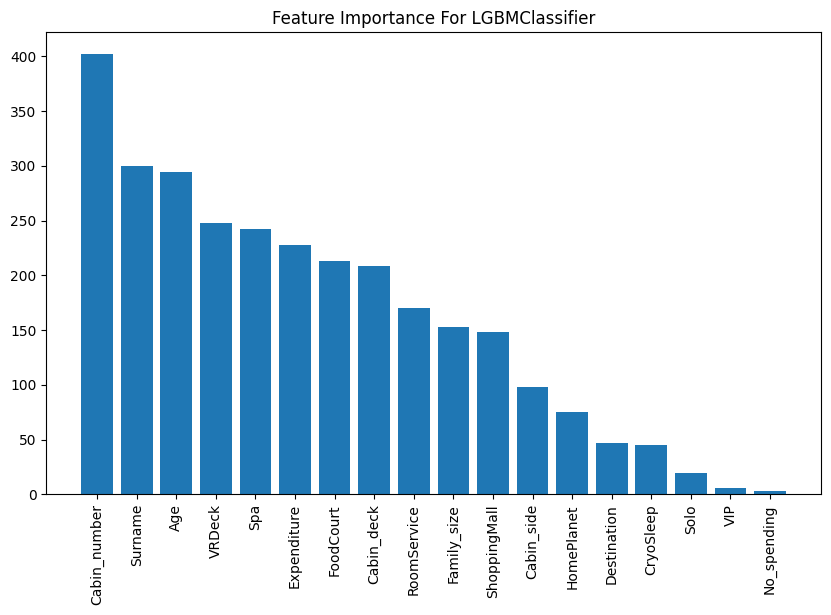

In [ ]:
# Get feature importance
feature_importances = best_clf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importance For LGBMClassifier")
plt.bar(range(X_train.shape[1]), feature_importances[indices])
plt.xticks(range(X_train.shape[1]), names, rotation=90)
plt.show()

### XGBClassifier

In [ ]:
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split,GridSearchCV

In [ ]:
y_train.head()

3600     True
1262     True
8612    False
5075     True
4758    False
Name: Transported, dtype: bool

In [ ]:
# create model instance
# Initialize cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
from sklearn.model_selection import GridSearchCV

# Define the XGBoost classifier
xgb_model = XGBClassifier()

# Define the parameter grid to search
param_grid = {
    'n_estimators': [2,5,10,30,50, 100, 200],
    'max_depth': [3, 5, 7,9],
    'learning_rate': [0.01, 0.1, 0.2,0.5,0.7,1,2,3],
    # Add other hyperparameters you want to tune
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=cv)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


In [ ]:
# Get the best model from the grid search
best_model = XGBClassifier(n_estimators = 200,max_depth = 5,learning_rate = 0.1)

# Record the time
start_time = time.time()

# Fit the best model on the entire training set
best_model.fit(X_train, y_train)

# Record the end time
end_time = time.time()
# Calculate the duration
duration = end_time - start_time
print("Training time:", duration, "seconds")

# Make predictions on the validation set
predictions = best_model.predict(X_val)

# Perform cross-validation with the best model
cross_val_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores:", cross_val_scores)

# Print the mean and standard deviation of cross-validation scores
print("Mean CV Score:", cross_val_scores.mean())
print("Standard Deviation of CV Scores:", cross_val_scores.std())


Training time: 6.281451463699341 seconds
Cross-Validation Scores: [0.82183908 0.79741379 0.80747126 0.82471264 0.82302158 0.78273381
 0.80863309 0.78417266 0.81582734 0.8028777 ]
Mean CV Score: 0.8068702968659556
Standard Deviation of CV Scores: 0.01445715691287694


In [ ]:
# Print classification report or other metrics
# Make predictions on the validation set
predictions = best_model.predict(X_val)
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

       False       0.81      0.82      0.81       863
        True       0.82      0.81      0.82       876

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739



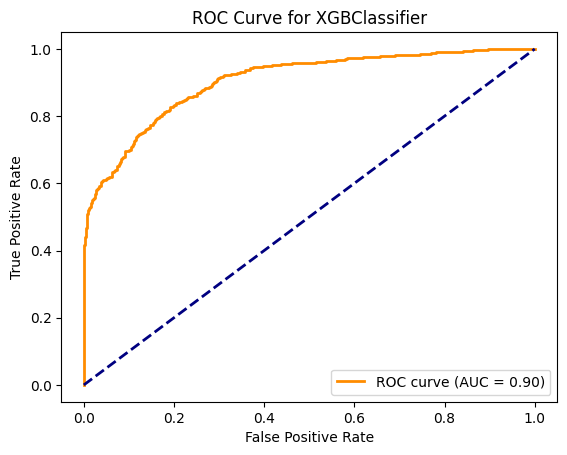

In [ ]:
## ROC of XGB
# Predict probabilities on the validation set
from sklearn.metrics import roc_curve, auc
y_prob = best_model.predict_proba(X_val)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBClassifier')
plt.legend(loc='lower right')
plt.show()

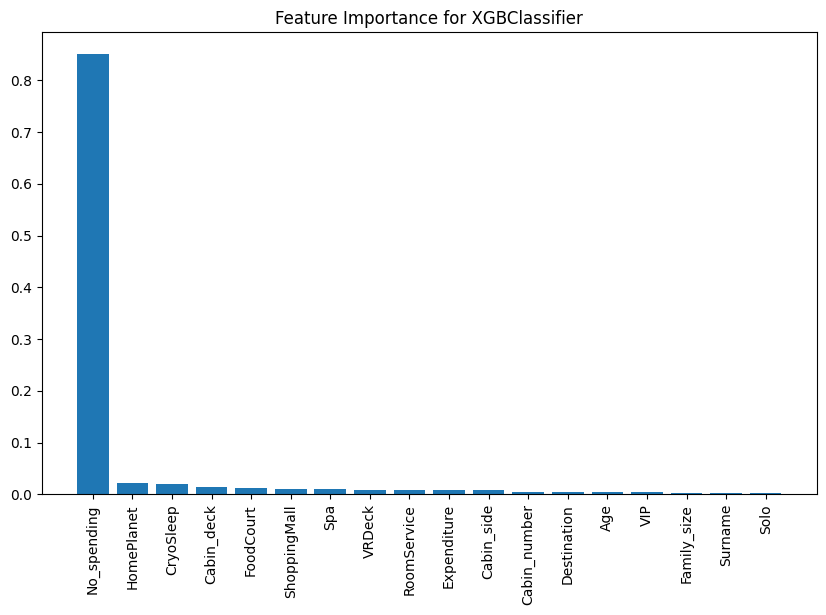

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'best_clf_xgb' is your best XGBoost model obtained from GridSearchCV

# Get feature importance
feature_importances = best_model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importance for XGBClassifier")
plt.bar(range(X_train.shape[1]), feature_importances[indices])
plt.xticks(range(X_train.shape[1]), names, rotation=90)
plt.show()